In [1]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

!git clone https://github.com/htymjun/da-sr
os.chdir('/content/da-sr')

from read import fw_to_np

Cloning into 'da-sr'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 91 (delta 50), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (91/91), 10.09 MiB | 6.94 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [2]:
# read cn and fw files
u, v, w, p, t, icount, x, y, z = fw_to_np('data')
# interpolate
uc = 0.5e0*(u[:-1,:,:]+u[1:,:,:])
vc = 0.5e0*(v[:,:-1,:]+v[:,1:,:])
wc = 0.5e0*(w[:,:,:-1]+w[:,:,1:])
xc = 0.5e0*(x[:-1]+x[1:])
yc = 0.5e0*(y[:-1]+y[1:])
zc = 0.5e0*(z[:-1]+z[1:])

In [3]:
Nx = 20   # height of highreso_data
Ny = 20   # width of highreso_data

nx = 10   # height of lowreso_data
ny = 10   # width of lowreso_data

# xh and xl are numpy array
xh = np.empty([int(len(uc[0,0,:])*len(uc[0,:,0])*len(uc[:,0,0])/Nx/Ny),2,Nx,Ny])
xl = np.empty_like(xh)

b = 0
for k in range(len(uc[0,0,:])):
  for i in range(0,len(uc[:,0,0]),Nx):
    for j in range(0,len(uc[0,:,0]),Ny):
      # highreso_data
      xh[b,0,:,:] = (uc[i:i+Nx,j:j+Ny,k]-np.mean(uc[:,:,:]))/np.std(uc[:,:,:])
      xh[b,1,:,:] = (vc[i:i+Nx,j:j+Ny,k]-np.mean(vc[:,:,:]))/np.std(vc[:,:,:])
      # lowreso_data
      xl[b,0,:,:] = cv2.resize(cv2.resize(xh[b,0,:,:],(nx,ny),interpolation=cv2.INTER_NEAREST),(Nx,Ny),interpolation=cv2.INTER_NEAREST)
      xl[b,1,:,:] = cv2.resize(cv2.resize(xh[b,1,:,:],(nx,ny),interpolation=cv2.INTER_NEAREST),(Nx,Ny),interpolation=cv2.INTER_NEAREST)
      b += 1

In [4]:
# define my dataset
class Dataset(torch.utils.data.Dataset):
  def __init__(self, highreso_data, lowreso_data):
    self.data = torch.tensor(highreso_data,dtype=torch.float32)
    self.targets = torch.tensor(lowreso_data,dtype=torch.float32)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    x = self.data[index]
    y = self.targets[index]
    return x, y

dataset = Dataset(xh,xl)  # xh and xl are numpy array
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

print("train_dataset size: {}".format(len(train_dataset)))
print("test_dataset size: {}".format(len(test_dataset)))

# make dataloader
train_batch = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=50,
                                          shuffle=True,
                                          num_workers=2)
test_batch = torch.utils.data.DataLoader(dataset=test_dataset,
                                         batch_size=50,
                                         shuffle=False,
                                         num_workers=2)

# check minibacth_dataset
for highreso_data, lowreso_data in train_batch:
    print("batch highreso_data size: {}".format(highreso_data.size()))  # batch size of highreso_data
    print("highreso data size: {}".format(highreso_data[0].size()))  # highreso_data size
    print("batch lowreso_data size: {}".format(lowreso_data.size()))  # batch size of lowreso_data
    print("lowreso data size: {}".format(lowreso_data[1].size()))  # lowreso_data size
    break

train_dataset size: 800
test_dataset size: 200
batch highreso_data size: torch.Size([50, 2, 20, 20])
highreso data size: torch.Size([2, 20, 20])
batch lowreso_data size: torch.Size([50, 2, 20, 20])
lowreso data size: torch.Size([2, 20, 20])


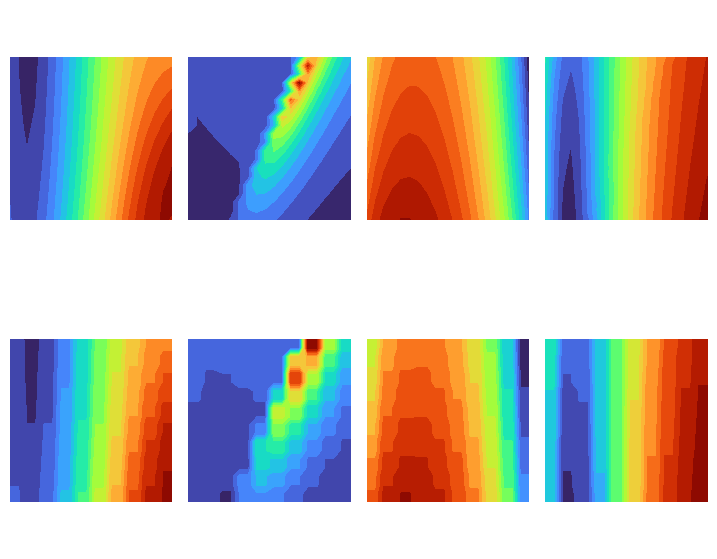

In [5]:
# display data
def cat_imshow(nx, ny, highreso_data, lowreso_data):
  plt.figure(figsize=(9, 7))
  for i in range(nx*ny):  # display X * Y data
    if i <= 3:
      velocity = highreso_data[i]
    elif i > 3 and i <= 7:
      velocity = lowreso_data[i-4]
    speed = np.sqrt(velocity[0,:,:]**2+velocity[1,:,:]**2)
    speed = speed.numpy()  # from Tensor to ndarray
    x = np.linspace(0,1,len(speed[:,0]))
    y = np.linspace(0,1,len(speed[0,:]))
    x, y = np.meshgrid(x,y)
    plt.subplot(nx, ny, i+1)
    plt.contourf(x, y, speed, cmap='turbo', levels=20)
    plt.axis('equal')
    plt.axis('off')  # delete scale
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

# check data
for highreso_data, lowreso_data in train_batch:
  cat_imshow(2, 4, highreso_data, lowreso_data)
  break

In [6]:
class RotatedConv1(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(RotatedConv1, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.freeze_conv_parameters()
    self.stride = stride
    self.padding = padding

  def rotate_filter(self, k):
    return torch.rot90(self.conv.weight, k, dims=(2, 3))

  def freeze_conv_parameters(self):
    for param in self.conv.parameters():
      param.requires_grad = False

  def forward(self, x):
    x1 = F.conv2d(x, self.rotate_filter(1), stride=self.stride, padding=self.padding)
    x2 = F.conv2d(x, self.rotate_filter(2), stride=self.stride, padding=self.padding)
    x3 = F.conv2d(x, self.rotate_filter(3), stride=self.stride, padding=self.padding)
    x4 = F.conv2d(x, self.rotate_filter(4), stride=self.stride, padding=self.padding)

    return x1,x2,x3,x4

class RotatedConv(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
    super(RotatedConv, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.freeze_conv_parameters()
    self.stride = stride
    self.padding = padding

  def rotate_filter(self, k):
    return torch.rot90(self.conv.weight, k, dims=(2, 3))

  def freeze_conv_parameters(self):
    for param in self.conv.parameters():
      param.requires_grad = False

  def forward(self, x):
    x1, x2, x3, x4 = x
    x1 = F.conv2d(x1, self.rotate_filter(1), stride=self.stride, padding=self.padding)
    x2 = F.conv2d(x2, self.rotate_filter(2), stride=self.stride, padding=self.padding)
    x3 = F.conv2d(x3, self.rotate_filter(3), stride=self.stride, padding=self.padding)
    x4 = F.conv2d(x4, self.rotate_filter(4), stride=self.stride, padding=self.padding)
    return x1,x2,x3,x4

class GCNN(nn.Module):
  def __init__(self):
    super(GCNN, self).__init__()
    self.conv1 = RotatedConv1(in_channels=2, out_channels=64, kernel_size=9, stride=1, padding=4)
    self.conv2 = RotatedConv(in_channels=64, out_channels=32, kernel_size=1, stride=1, padding=0)
    self.conv3 = RotatedConv(in_channels=32, out_channels=2, kernel_size=5, stride=1, padding=2)
  def forward(self, x):
    # Z2-P4 conv
    x1,x2,x3,x4 = self.conv1(x)
    # P4-P4 conv
    x1,x2,x3,x4 = self.conv2((x1,x2,x3,x4))
    x1,x2,x3,x4 = self.conv3((x1,x2,x3,x4))
    # pooling
    x1 = F.max_pool2d(x1, kernel_size=2, stride=1, padding=0)
    x2 = F.max_pool2d(x2, kernel_size=2, stride=1, padding=0)
    x3 = F.max_pool2d(x3, kernel_size=2, stride=1, padding=0)
    x4 = F.max_pool2d(x4, kernel_size=2, stride=1, padding=0)
    x = torch.max(torch.max(x1,x2),torch.max(x3,x4))
    # up-scaling
    x = F.interpolate(x,size=(20,20), mode='bicubic',align_corners=False)
    return x

# use GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = GCNN().to(device)
print(net)
# check device
print("Device: {}".format(device))

GCNN(
  (conv1): RotatedConv1(
    (conv): Conv2d(2, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  )
  (conv2): RotatedConv(
    (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (conv3): RotatedConv(
    (conv): Conv2d(32, 2, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)
Device: cuda


In [7]:
# define loss function
criterion = nn.MSELoss()

# define optimizer
optimizer = optim.Adam(net.parameters())

In [20]:
# make lists to store MSE
train_loss_list = []
test_loss_list = []

# do machine learning
epoch = 2
for i in range(epoch):
  # progress var
  print('---------------------------------------------')
  print("Epoch: {}/{}".format(i+1, epoch))

  # initialize loss
  train_loss = 0
  test_loss = 0

  # train GCNN
  net.train()
  # load mini batch
  #i = 0
  for highreso_data, lowreso_data in train_batch:

    # highreso_data size = 800, 16 * 50 = 800
    print(highreso_data.size(),highreso_data[0,0,0,0],highreso_data[1,0,0,0])

    highreso_data.requires_grad_()
    lowreso_data.requires_grad_()
    # transfer Tensor to GPU
    highreso_data = highreso_data.to(device)
    lowreso_data = lowreso_data.to(device)

    # initialize grad
    optimizer.zero_grad()
    # calc pred
    y_pred = net(lowreso_data)
    # calc loss
    loss = criterion(y_pred, highreso_data)
    # calc grad
    loss.backward()
    # update parameters
    optimizer.step()
    # stock train loss
    train_loss += loss.item()
    #i += 1

  # calc mean loss
  batch_train_loss = train_loss / len(train_batch)

  # evaluate GCNN
  net.eval()
  with torch.no_grad():
    for highreso_data, lowreso_data in test_batch:
      # transfer Tensor to GPU
      highreso_data = highreso_data.to(device)
      lowreso_data = lowreso_data.to(device)
      # calc pred
      y_pred = net(lowreso_data)
      # calc loss
      loss = criterion(y_pred, highreso_data)
      # stock test loss
      test_loss += loss.item()

  # calc mean loss
  batch_test_loss = test_loss / len(test_batch)

  print("Train_Loss: {:.4f}".format(batch_train_loss))
  print("Test_Loss: {:.4f}".format(batch_test_loss))

  train_loss_list.append(batch_train_loss)
  test_loss_list.append(batch_test_loss)

---------------------------------------------
Epoch: 1/2
torch.Size([50, 2, 20, 20]) tensor(0.4787) tensor(-2.0567)
torch.Size([50, 2, 20, 20]) tensor(0.2844) tensor(0.9061)
torch.Size([50, 2, 20, 20]) tensor(0.9499) tensor(0.6986)
torch.Size([50, 2, 20, 20]) tensor(-0.3342) tensor(0.0727)
torch.Size([50, 2, 20, 20]) tensor(0.1121) tensor(0.2888)
torch.Size([50, 2, 20, 20]) tensor(0.3821) tensor(-1.6058)
torch.Size([50, 2, 20, 20]) tensor(0.5230) tensor(0.5347)
torch.Size([50, 2, 20, 20]) tensor(0.1990) tensor(0.5974)
torch.Size([50, 2, 20, 20]) tensor(1.0572) tensor(0.5349)
torch.Size([50, 2, 20, 20]) tensor(0.9066) tensor(0.1713)
torch.Size([50, 2, 20, 20]) tensor(1.0818) tensor(0.6671)
torch.Size([50, 2, 20, 20]) tensor(-2.4475) tensor(-1.1540)
torch.Size([50, 2, 20, 20]) tensor(0.9236) tensor(0.5408)
torch.Size([50, 2, 20, 20]) tensor(0.2918) tensor(-2.0567)
torch.Size([50, 2, 20, 20]) tensor(-1.5784) tensor(0.6509)
torch.Size([50, 2, 20, 20]) tensor(1.0145) tensor(0.9580)
Train_Lo